# Tarea 2 - Regresion Polinomial & Feature engineering

### Parte 1 - Modelo exponencial de covid-19 usando feature-eng

Usando el ejemplo de covid-19 en el notebook de feature-eng (https://colab.research.google.com/drive/1sJV2HG7tQgCGKES3-dIclzHQJ9qAWB3b?usp=sharing) crear un modelo de covid-19 para Guatemala.

* Convertir la fecha a un entero "número de día", por ejemplo si se usan datos desde el 22 de abril, este es el día 0, el 23 es el día 1.
* Aplicar regresión lineal sobre la variable "Confirmed" transformada.
* Una vez entrenado el modelo usarlo para aproximar la cantidad de casos confirmados para el 6 de Junio. Se debe reportar la cantidad de casos, no la cantidad transformada obtenida.

In [48]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
import datetime, os
import math

if tf.__version__.startswith("2."):
  import tensorflow.compat.v1 as tf
  tf.compat.v1.disable_v2_behavior()
  tf.compat.v1.disable_eager_execution()

### Carga de datos

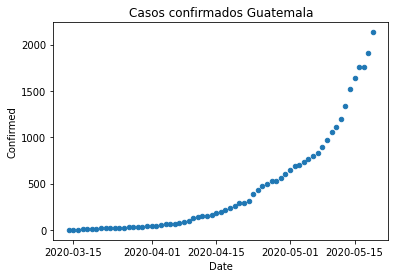

In [2]:
covid_data = pd.read_csv('covid_19_clean_complete.csv')
covid_data["Date"] = pd.to_datetime(covid_data["Date"],infer_datetime_format = True)
covid_data.head()

GT_confirmed = covid_data[(covid_data["Country/Region"] == 'Guatemala') & (covid_data["Confirmed"] > 0)].copy()
GT_confirmed.plot.scatter(x = "Date",y="Confirmed", title='Casos confirmados Guatemala')

Aplicamos logaritmo natural a los datos para obtener algo más parecido a un comportamiento lineal

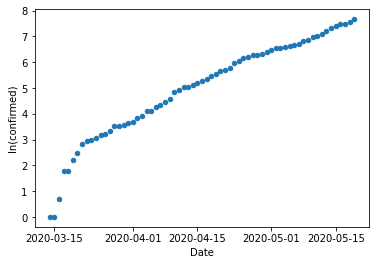

In [3]:
GT_confirmed["ln(confirmed)"] = np.log(GT_confirmed["Confirmed"])
GT_confirmed.plot.scatter(x = "Date",y="ln(confirmed)")

Removemos los datos de los días previos al 23 de marzo, donde la tendencia lineal todavía no aparece claramente, para evitar ruido en el modelo. También convertimos la fecha al número de días desde el 22 de marzo.

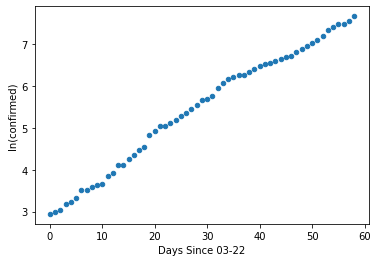

In [5]:
GT_confirmed_post24 = GT_confirmed.copy()[GT_confirmed.Date >= '2020-03-22']
GT_confirmed_post24["Days Since 03-22"] = np.arange(len(GT_confirmed_post24))
GT_confirmed_post24.plot.scatter(x = "Days Since 03-22",y="ln(confirmed)")

## Modelo de regresión lineal en TF (adaptado de la tarea anterior)

In [56]:
class SimpleLinearRegression:
    def __init__(self, x, y):
        self.x = x.reshape(-1, 1)
        self.y = y.reshape(-1, 1)
        
    def train(self, epochs, lr, print_rate=200):
        n_sample = len(self.x)

        g = tf.Graph()
        with g.as_default():
            placeholder_x = tf.placeholder(tf.float64, [n_sample, 1], "x")
            placeholder_y = tf.placeholder(tf.float64, [n_sample, 1], "y")
            feed = {placeholder_x: self.x, placeholder_y: self.y}

            with tf.Session() as session:    
                (epoch_op, error_op) = self.__gradient_descent(placeholder_x, placeholder_y, lr)

                session.run(tf.global_variables_initializer())

                # TODO: extract post-epoch code to other function that takes epoch,error
                for epoch in range(1, epochs + 1):
                    error = session.run([epoch_op, error_op], feed)[1]

                    if epoch % print_rate == 0 or epoch == epochs:
                        print("epoch:" + str(epoch) + " error: " + str(error))
                        if math.isinf(error):
                            print("terminando por divergencia")
                            break

                session.close()
        
    def __gradient_descent(self, x, y, lr):
        n_samples = x.shape[0]
        n_independent_vars = x.shape[1] + 1 #contando el intercepto

        ones = tf.ones([n_samples, 1], tf.float64)
        x = tf.concat([x, ones], axis = 1)

        initial_weights = tf.zeros([n_independent_vars, 1], tf.float64)
        weights = tf.Variable(name="Weights", initial_value=initial_weights)

        y_hat = tf.matmul(x, weights)
        error = 1/2 * tf.reduce_mean(tf.math.square(y - y_hat))
        gradients = tf.gradients(error, weights)
        adjustment = tf.scalar_mul(-lr, gradients[0])
        update_weights = tf.assign(weights, (tf.add(weights, adjustment))) 
        return (update_weights, error)

In [57]:
x = GT_confirmed_post24["Days Since 03-22"].to_numpy()
y = GT_confirmed_post24["ln(confirmed)"].to_numpy()
model = SimpleLinearRegression(x, y)

model.train(1000, 0.001, 100)

59
epoch:100 error: 1.1546623661169637
epoch:200 error: 1.0975980571749726
epoch:300 error: 1.0433848831545516
epoch:400 error: 0.9918803912600443
epoch:500 error: 0.9429492461418457
epoch:600 error: 0.8964628742835969
epoch:700 error: 0.8522991261570555
epoch:800 error: 0.8103419552569031
epoch:900 error: 0.770481113172111
epoch:1000 error: 0.73261185989262


### Parte 2 - Modelo polinomial de calidad de vinos

Es permitido utilizar [sklearn.preprocessing.polynomialfeatures](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html)


### Instrucciones

1. Seleccionar y transformar(generando las combinaciones polinomiales para un polinomio de grado dos o tres a elección) las features que considere que son las mejores para predecir la calidad del vino, utilizar como minimo 2 features. Para seleccionar las features, hacer un analisis exploratorio por ejemplo(pero no limitado a ):  graficando y viendo la forma en que se comportan los datos.

 Por ejemplo, se tienen las features "a" y "b" y seleccionamos polinomio de grado 2, hacemos feature engineering para obtener :
 
 $[a,b,a^{2},b^{2},ab]$
 
 No olvidar el "bias" (parámetro multiplicado por 1) ,con lo cual el dataset puede quedar con las columnas:
 
 $[1,a,b,a^{2},b^{2},ab]$
2. Una vez transformada la data aplicar regresion lineal con las features polinomiales usando Tensorflow.

Requisitos adicionales:
* Se debe agregar al notebook un screenshot del grafo de tensorboard, simplificando(usando  names , y name_scope como visto en clase).

* Se debe generar un directorio de logs de tensorboard para cada corrida/experimento , con cada directorio identificando facilmente la configuración del experimento como visto en clase, por ejemplo para un experimento con learning rate = 0.1 , y polinomio grado 2  crear un directorio: lr=0.1_polinomio_grado=2. (Agregar al notebook un screenshot de estas gráficas)

* Concluir en markdown cual es el mejor modelo para este caso basado en la comparativa entre curvas de costo/error en tensorboard.

In [1]:
import pandas as pd

In [2]:
data = pd.read_csv('winequality-red.csv')

### Red Wine Quality Data

Se aplicará regresión para crear un modelo de la calidad de vino en función de características del mismo, siendo 1 el peor vino y 10 el mejor.

Variables de entrada:
1. fixed acidity 
2. volatile acidity 
3. citric acid 
4. residual sugar 
5. chlorides 
6. free sulfur dioxide 
7. total sulfur dioxide 
8. density 
9. pH 
10. sulphates 
11. alcohol 

Varaible a predecir: 
12. quality (puntuacion  entre 0 y 10) 



In [3]:
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
